In [1]:
from kaggle.competitions import twosigmanews
import pandas as pd
import numpy as np
import datetime
from itertools import chain
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

env = twosigmanews.make_env()
(market_train_df, news_train_df) = env.get_training_data()

market_train_df = market_train_df.tail(300000)
news_train_df = news_train_df.loc[news_train_df['time']>market_train_df.iloc[0].time.normalize()]

Loading the data... This could take a minute.
Done!


In [2]:
#Feature Extraction modeled on A Simple Model - Using Market and News Data by Bruno G. do Amaral on Kaggle

news_cols_agg = {
    'urgency': ['min', 'count'],
    'takeSequence': ['max'],
    'bodySize': ['min', 'max', 'mean', 'std'],
    'wordCount': ['min', 'max', 'mean', 'std'],
    'sentenceCount': ['min', 'max', 'mean', 'std'],
    'companyCount': ['min', 'max', 'mean', 'std'],
    'marketCommentary': ['min', 'max', 'mean', 'std'],
    'relevance': ['min', 'max', 'mean', 'std'],
    'sentimentNegative': ['min', 'max', 'mean', 'std'],
    'sentimentNeutral': ['min', 'max', 'mean', 'std'],
    'sentimentPositive': ['min', 'max', 'mean', 'std'],
    'sentimentWordCount': ['min', 'max', 'mean', 'std'],
    'noveltyCount12H': ['min', 'max', 'mean', 'std'],
    'noveltyCount24H': ['min', 'max', 'mean', 'std'],
    'noveltyCount3D': ['min', 'max', 'mean', 'std'],
    'noveltyCount5D': ['min', 'max', 'mean', 'std'],
    'noveltyCount7D': ['min', 'max', 'mean', 'std'],
    'volumeCounts12H': ['min', 'max', 'mean', 'std'],
    'volumeCounts24H': ['min', 'max', 'mean', 'std'],
    'volumeCounts3D': ['min', 'max', 'mean', 'std'],
    'volumeCounts5D': ['min', 'max', 'mean', 'std'],
    'volumeCounts7D': ['min', 'max', 'mean', 'std']
}

In [3]:
#Inject DOMAIN EXPERTISE
def augment_market_data(market_df):
    market_df['dollar_volume'] = np.multiply(market_df['volume'], np.divide(np.add(market_df['open'], market_df['close']),2))
    market_df['day_change'] = np.divide(np.subtract(market_df['close'],market_df['open']), market_df['open'])
    for time in ['Open','Close']:
        for adj in ['Raw','Mktres']:
            market_df["change_"+time+"_"+adj] = np.subtract(market_df['returns'+time+'Prev'+adj+'1'], market_df['returns'+time+'Prev'+adj+'10'])


In [4]:
def augment_news_data(news_train_df):
    news_train_df['sentimentScore'] = news_train_df['sentimentPositive'] - news_train_df['sentimentNegative']
    news_cols_agg['sentimentScore'] = ['min','max','mean','std']
    news_train_df['headlineLength'] = news_train_df['headline'].apply(len)
    news_cols_agg['headlineLength'] = ['min','max','mean','std']
    news_train_df['headlineWordLength'] = news_train_df['headline'].apply(lambda x: len(x.split()))
    news_cols_agg['headlineWordLength'] = ['min','max','mean','std']
    news_train_df['audienceCount'] = news_train_df['audiences'].apply(lambda x: len(x.split(',')))
    news_cols_agg['audienceCount'] = ['min','max','mean','std']
    news_train_df['subjectsCount'] = news_train_df['subjects'].apply(lambda x: len(x.split(',')))
    news_cols_agg['subjectsCount'] = ['min','max','mean','std']

In [5]:
augment_market_data(market_train_df)
market_train_df.tail()

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe,dollar_volume,day_change,change_Open_Raw,change_Open_Mktres,change_Close_Raw,change_Close_Mktres
4072951,2016-12-30 22:00:00+00:00,ZIOP.O,ZIOPHARM Oncology Inc,1608829.0,5.35,5.37,-0.003724,0.000000,0.000536,-0.001868,-0.165367,-0.138042,-0.139597,-0.135913,0.051189,0.0,8.623323e+06,-0.003724,0.138042,0.134046,0.161642,0.140133
4072952,2016-12-30 22:00:00+00:00,ZLTQ.O,ZELTIQ Aesthetics Inc,347830.0,43.52,43.62,-0.000689,0.000000,-0.000515,0.000493,0.002996,0.002989,0.008213,0.003210,-0.048555,0.0,1.515495e+07,-0.002293,-0.002989,-0.002717,-0.003685,-0.008727
4072953,2016-12-30 22:00:00+00:00,ZNGA.O,Zynga Inc,7396601.0,2.57,2.58,-0.011538,0.000000,-0.006004,-0.001034,-0.091873,-0.078571,-0.077252,-0.077188,0.011703,0.0,1.904625e+07,-0.003876,0.078571,0.076154,0.080334,0.071248
4072954,2016-12-30 22:00:00+00:00,ZTO.N,Unknown,3146519.0,12.07,12.50,-0.029743,0.007252,-0.028460,0.006719,-0.065066,-0.042146,-0.078104,-0.043813,0.083367,1.0,3.865499e+07,-0.034400,0.049398,0.050532,0.035323,0.049645
4072955,2016-12-30 22:00:00+00:00,ZTS.N,Zoetis Inc,1701204.0,53.53,53.64,-0.001678,0.003091,0.005060,0.002885,0.023127,0.028177,0.026566,0.028719,-0.016220,1.0,9.115902e+07,-0.002051,-0.025086,-0.025834,-0.024805,-0.021506


In [6]:
augment_news_data(news_train_df)
news_train_df.tail()

,time,sourceTimestamp,firstCreated,sourceId,headline,urgency,takeSequence,provider,subjects,audiences,bodySize,companyCount,headlineTag,marketCommentary,sentenceCount,wordCount,assetCodes,assetName,firstMentionSentence,relevance,sentimentClass,sentimentNegative,sentimentNeutral,sentimentPositive,sentimentWordCount,noveltyCount12H,noveltyCount24H,noveltyCount3D,noveltyCount5D,noveltyCount7D,volumeCounts12H,volumeCounts24H,volumeCounts3D,volumeCounts5D,volumeCounts7D,sentimentScore,headlineLength,headlineWordLength,audienceCount,subjectsCount
9328745,2016-12-30 21:56:06+00:00,2016-12-30 21:56:06+00:00,2016-12-30 21:56:06+00:00,fc80724160cc7bf4,"INTREXON - ON DEC 30, CO, THIRD SECURITY EXECU...",1,1,RTRS,"{'BLR', 'HECA', 'PHMR', 'MRCH', 'US', 'RTRS', ...","{'E', 'U'}",0,1,,False,1,35,{'XON.N'},Intrexon Corp,1,1.0,1,0.115706,0.410445,0.473849,35,0,0,0,0,0,0,1,10,10,10,0.358143,148,28,2,9
9328746,2016-12-30 21:56:28+00:00,2016-12-30 21:56:28+00:00,2016-12-30 21:56:06+00:00,2e3e5407e186dd51,INTREXON CORP - AMENDMENT EXTENDS TERM OF SERV...,1,2,RTRS,"{'BLR', 'DBT', 'HECA', 'PHMR', 'MRCH', 'BACT',...","{'E', 'U'}",0,1,,False,1,20,{'XON.N'},Intrexon Corp,1,1.0,1,0.032272,0.122635,0.845093,20,0,0,1,1,1,1,2,11,11,11,0.812821,100,17,2,13
9328747,2016-12-30 21:57:00+00:00,2016-12-30 21:57:00+00:00,2016-12-30 21:57:00+00:00,cef1bb88f92ca104,EQUITY ALERT: Rosen Law Firm Announces Investi...,3,1,BSW,"{'CMSS', 'CLJ', 'GEN', 'NEWR', 'HECA', 'PHMR',...","{'BSW', 'CNR'}",3734,1,,False,16,664,"{'SGEN.O', 'SGEN.OQ'}",Seattle Genetics Inc,1,1.0,-1,0.651900,0.227707,0.120393,360,0,0,3,4,4,1,2,18,41,41,-0.531507,120,17,2,15
9328748,2016-12-30 21:58:53+00:00,2016-12-30 21:58:53+00:00,2016-12-30 21:58:53+00:00,c26c3df1804571a6,PROFESSIONAL DIVERSITY NETWORK INC - FILES FOR...,1,1,RTRS,"{'BLR', 'SWIT', 'ITSE', 'SISU', 'BACT', 'TMT',...","{'E', 'U'}",0,1,,False,1,23,"{'IPDN.O', 'IPDN.OQ'}",Professional Diversity Network Inc,1,1.0,-1,0.816252,0.126928,0.056819,23,0,0,0,0,0,0,0,3,3,3,-0.759433,131,22,2,13
9328749,2016-12-30 22:00:00+00:00,2016-12-30 22:00:00+00:00,2016-12-30 22:00:00+00:00,daea2d46dc7f5303,"JPMorgan China Region Fund, Inc. Board to Subm...",3,1,BSW,"{'CMSS', 'NEWR', 'INVT', 'BACT', 'BSUP', 'INDS...","{'BSW', 'CNR'}",2969,1,,False,15,492,{'JFC.N'},JPMorgan China Region Fund Inc,1,1.0,1,0.130152,0.388845,0.481002,383,0,0,0,0,0,0,0,0,0,0,0.350850,117,19,2,14


In [7]:
globaltime = market_train_df.iloc[0]['time'].timetz()

def get_dates(times):
    times = times+pd.DateOffset(hours=2)
    return times.apply(lambda ts: pd.Timestamp.combine(ts.date(),globaltime))

In [8]:
def merge_news_market_data(news_df, market_df):
    
    #represent assetcodes as lists
    news_df['assetCodes'] = news_df['assetCodes'].str.findall(f"'([\w\./]+)'")    

    #convert times to dates
    news_df['time'] = get_dates(news_df['time'])

    # assetCodes_expanded and assetCodes_index s.t. assetCodes_expanded[i] in news_df.iloc[assetCodes_index[i]].assetCodes
    assetCodes_expanded = list(chain(*news_df['assetCodes']))
    assetCodes_index = news_df.index.repeat( news_df['assetCodes'].apply(len) )

    # helper table for merge
    df_assetCodes = pd.DataFrame({'level_0': assetCodes_index, 'assetCode': assetCodes_expanded})

    # Get new dataframe with 1 row per assetcode, per news article
    news_cols = ['time', 'assetCodes'] + sorted(news_cols_agg.keys())
    news_df_expanded = pd.merge(df_assetCodes, news_df[news_cols], left_on='level_0', right_index=True, suffixes=(['','_old']))
    del news_df
    
    news_df_aggregated = news_df_expanded.groupby(['time', 'assetCode']).agg(news_cols_agg)

    # Free memory
    del df_assetCodes, assetCodes_expanded, assetCodes_index, news_cols, news_df_expanded, 

    # save space with floats
    news_df_aggregated = news_df_aggregated.apply(np.float32)

    #flatten columns
    news_df_aggregated.columns = ['_'.join(col).strip() for col in news_df_aggregated.columns.values]

    market_df = market_df.join(news_df_aggregated, on=['time', 'assetCode'])

    del news_df_aggregated
    
    return market_df

In [9]:
def getxy(merged_df):
    y = merged_df['returnsOpenNextMktres10'].values
    X = merged_df.drop(columns = ['returnsOpenNextMktres10', 'assetCode','assetName','time', 'universe'], inplace=False)
    X.fillna(0, inplace=True)
    X = X.values
    return X, y

In [10]:
def clean_data(merged_df):
    merged_df = merged_df[merged_df["returnsOpenNextMktres10"]>-1]
    merged_df = merged_df[merged_df["returnsOpenNextMktres10"]<1]
    merged_df = merged_df[merged_df["close"] < 2*merged_df["open"]]
    merged_df = merged_df[2*merged_df["close"] > merged_df["open"]]
    return merged_df

In [11]:
merged_data = merge_news_market_data(news_train_df, market_train_df)
del market_train_df, news_train_df
cols = list(merged_data.drop(columns = ['returnsOpenNextMktres10', 'universe'], inplace=False).columns)
print("Merged!")

train, validate, test = np.split(merged_data.sample(frac=1), [int(.6*len(merged_data)), int(.8*len(merged_data))])

train_indices = train.index.values
val_indices = validate.index.values
test_indices = test.index.values

Merged!


In [12]:
Xtrain,ytrain = getxy(clean_data(merged_data.loc[train_indices]))
Xval,yval = getxy(clean_data(merged_data.loc[val_indices]))
Xtest,ytest = getxy(merged_data.loc[test_indices])
del merged_data

In [13]:
model = linear_model.LinearRegression()
model.fit(Xtrain,ytrain)
#print(model.score(Xtest, ytest))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [14]:
def training_accuracy(y_pred, y_true):
    MSE = metrics.mean_squared_error(y_true, y_pred)
    accuracy = metrics.accuracy_score(np.array(y_true)>0,np.array(y_pred)>0)
    plt.hist(y_true, bins=np.linspace(-0.5,0.5,150), alpha=0.3)
    plt.hist(y_pred, bins=np.linspace(-0.5,0.5,150), alpha=0.3, color='darkorange')
    plt.legend(['Ground truth', 'Predicted'])
    plt.xlabel("Confidence")
    plt.ylabel("Count")
    plt.title("predicted confidence")
    plt.show()
    return MSE, accuracy

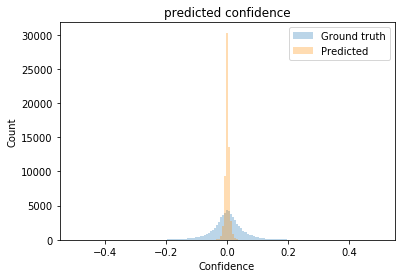

(0.004229868217330871, 0.5369666666666667)

In [15]:
training_accuracy(model.predict(Xtest),ytest)

In [21]:
def error_histogram(y_pred, y_true):
    plt.style.use("seaborn")
    error = np.subtract(y_pred, y_true)
    print(np.std(error))
    plt.hist(error, bins = np.linspace(-0.25, 0.25, 100), alpha=0.3, color='r')
    plt.xlabel("Error in 10-day return")
    plt.ylabel("Frequency")
    plt.title("Error Histogram")
    plt.show()
    

0.0650367971298488


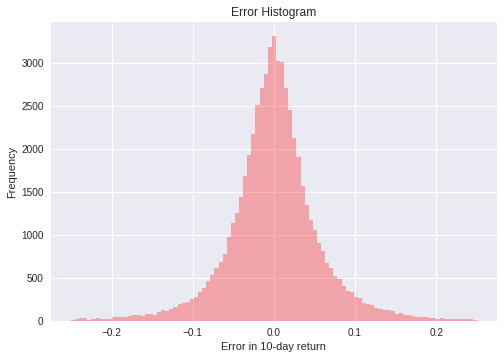

In [22]:
error_histogram(model.predict(Xtest), ytest)

In [ ]:
'''
X = merged_data.loc[train_indices].drop(columns = ['returnsOpenNextMktres10', 'assetCode','assetName','time', 'universe'], inplace=False)
X.fillna(0, inplace=True)
importances = []
for i, column in enumerate(X.columns):
    importances.append((model.coef_[i]*np.std(X[column]),column))
'''

In [ ]:
'''
importances.sort(key=lambda x: -abs(x[0]))
plotcount = 7
plt.figure(figsize=(4,2))
plt.bar(x = range(plotcount), height = [x[0] for x in importances[:plotcount]])
plt.xticks(range(plotcount),[importance[1] for importance in importances[:plotcount]], fontsize='small',rotation='45', horizontalalignment='right')
plt.ylabel('Feature Significance')
plt.show()
'''

The model has been trained. Run the model on the provided test data.

In [ ]:
def getX(merged_df):
    X = merged_df.drop(columns = ['assetCode','assetName','time'], inplace=False)
    X.fillna(0, inplace=True)
    X = X.values
    return X

In [ ]:
def make_predictions(merged_obs_df, predictions_df):
    X = getX(merged_obs_df)
    predictions = model.predict(X)
    predictions = np.divide(predictions - np.min(predictions), np.max(predictions)-np.min(predictions))
    predictions = 2*predictions-1
    predictions_df.confidenceValue = predictions

In [ ]:
days = env.get_prediction_days()

In [ ]:
i=0
for (market_obs_df, news_obs_df, predictions_template_df) in days:
    i+=1
    if i%10 == 0:
        print(i)
    augment_market_data(market_obs_df)
    augment_news_data(news_obs_df)
    merged_obs_df = merge_news_market_data(news_obs_df, market_obs_df)
    make_predictions(merged_obs_df, predictions_template_df)
    env.predict(predictions_template_df)
print("Done!")

In [ ]:
env.write_submission_file()